# Experiment: Flashed gratings

### Initialization

#### Imports

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as sts
import pickle as pkl
import ipywidgets as widgets
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
import sys
from matplotlib import cm
sys.path.insert(0, '../model/')

# color maps
cmap_hot = cm.get_cmap('hot')
cmap_viridis = cm.get_cmap('viridis')
cmap_jet = cm.get_cmap('jet')

In [3]:

data_folder = "../data/"
stim_file = "Stiminfo_PVCre_2021_0012_s06_e14.csv"
spike_times_file = "Spiketimes_PVCre_2021_0012_s06_e14.npy"

key_symbol = {'pair':'$(\\theta,\phi)$', 'orientation':'$\\theta$', 'phase':'$\phi$'}

In [9]:
file = open("dump_l.pkl", 'rb')
pair_id = None
data = pkl.load(file)
print(data.keys())
for key, value in data.items():
    globals()[key] = value
file.close()

dict_keys(['data_folder', 'stim_file', 'spike_times_file', 'key_symbol', 'stim', 'num_trial', 'stim_val', 'trial_stim_id', 'key_list', 'stim_id_trial', 'num_stim', 'key', 'pair_id', 'trial_pair_id', 'pair_val', 'pair_trial_id', 'spike_times', 'num_unit', 'num_spike', 'spike_count_rate', 'avg_firing_rate', 'firing_rate', 'stim_num_trial', 'stim_hist', 'optimal_avg_firing_rate', 'latest_spike_time', 'dt', 'exp_time', 'B_stim', 'trials', 't_on', 't_off', 'B_spike', 'trial_range', 'units', 'orientation', 'phase', 'trial_spike_times', 'delta_t_on', 'delta_t_off', 'subseq_trials', 'subseq_spike_times', 'subseq_spike_times_locked', 'time_range', 'unit_id_2', 'p1', 'p2', 'delta_t', 'time_range_smoothing', 'period_1_dist', 'period_2_dist', 'period_3_dist', 'num_units', 'max_p_1', 'max_p_2', 'max_p_3', 'delta_2', 'delta_3', 't_p1', 't_p2', 'subseq_spike_times_locked_2', 'B_spike_fixed', 'B_stim_original', 'B_spike_smooth', 'B_stim_total', 'R', 'R_pair_smoothed', 'Rp', 'firing_rates_noise_red', '

In [ ]:
import pickle
with open('dump_l.pkl', 'wb') as f:
    pickle.dump({k: globals()[k] for k in [
        'data_folder', 'stim_file', 'spike_times_file', 'key_symbol', 
        'stim', 'num_trial', 'stim_val', 'trial_stim_id', 'key_list', 'stim_id_trial', 'num_stim', 'key', 'pair_id', 'trial_pair_id', 'pair_val', 'pair_trial_id',
        'spike_times', 'num_unit', 'num_spike', 'spike_count_rate', 'avg_firing_rate', 'firing_rate', 'stim_num_trial', 'stim_hist', 'optimal_avg_firing_rate',
        'latest_spike_time', 'dt', 'exp_time', 'B_stim', 'trials', 't_on', 't_off', 'B_spike', 'trial_range', 'units', 'orientation', 'phase', 'trial_spike_times',
        'delta_t_on', 'delta_t_off', 'subseq_trials', 'subseq_spike_times', 'subseq_spike_times_locked', 'time_range', 'unit_id_2', 'p1', 'p2', 'delta_t', 'time_range_smoothing',
        'period_1_dist', 'period_2_dist', 'period_3_dist', 'num_units', 'max_p_1', 'max_p_2', 'max_p_3', 'delta_2', 'delta_3', 't_p1', 't_p2', 'subseq_spike_times_locked_2',
        'B_spike_fixed', 'B_stim_original', 'B_spike_smooth', 'B_stim_total', 'R', 'R_pair_smoothed', 'Rp', 'firing_rates_noise_red', 'firing_rates_flat', 'firing_rates_in_trials', 'avg_firing_rates',
        'avg_fr_blur', 'avg_firing_rates', 'avg_firing_rates_pca', 'param_corr', 'avg_firing_rates_pca_', 'embed'
        ]}, f)

#### Load the stimulus data
**Stimulus data layout:**
```
stim_val = {'pair': [(or1, ph1), (or2, ph2), ...], 'orientation': [...], 'phase': [...]}
stim_id_trial = {'pair': [id1, id2, ...], 'phase': [..], ...}   # corresponding trials
pair_trial_id[orientation_id][phase_id] = [Trial ids]
```

In [4]:
# Stimulus DataFrame
stim = pd.read_csv(data_folder + stim_file)
num_trial = len(stim)
stim_val = {}
trial_stim_id = {}
# 50 trials per orientation-phase pair
stim_val['pair'], trial_stim_id['pair'] = np.unique(stim[['grat_orientation', 'grat_phase']], return_inverse=True, axis=0) 
# 1000 trials per orientation
stim_val['orientation'], trial_stim_id['orientation'] = np.unique(stim['grat_orientation'], return_inverse=True) 
# 1000 trials per phase
stim_val['phase'], trial_stim_id['phase'] = np.unique(stim['grat_phase'], return_inverse=True) 
key_list = ['pair', 'orientation', 'phase']
stim_id_trial = {}
num_stim = {}
for key in key_list:
    stim_id_trial[key] = [np.where(trial_stim_id[key] == i)[0] for i in range(len(stim_val[key]))]
    num_stim[key] = len(stim_val[key])

def pair_id(i):
    return (int(i//num_stim['orientation']), i%num_stim['orientation'])

trial_pair_id = np.array([pair_id(i) for i in trial_stim_id['pair']], dtype=object)
pair_val = stim_val['pair'].reshape(num_stim['orientation'], num_stim['phase'],2)

# for each (orientation_id = i, phase_id = j) find the trial indices
pair_trial_id = np.ndarray((num_stim['orientation'], num_stim['phase']), dtype=object)
for i in range(num_stim['pair']):
    pair_trial_id[pair_id(i)] = stim_id_trial['pair'][i]

In [5]:
stim.head()

Unnamed: 0  grat_orientation  grat_phase  stimvals  stim_ontime  \
0           0              45.0        36.0       102       2.5005   
1           1               0.0        18.0         1       2.6195   
2           2             162.0       288.0       376       2.7030   
3           3               0.0        54.0         3       2.7865   
4           4             108.0        36.0       242       2.8700   

   stim_offtime  
0        2.5839  
1        2.7028  
2        2.7863  
3        2.8699  
4        2.9534

In [6]:
print(', '.join(stim_val.keys()))
print(stim_val['pair'].shape)
print(stim_val['orientation'].shape, stim_val['phase'].shape)

pair, orientation, phase
(400, 2)
(20,) (20,)


In [7]:
print(stim_id_trial['pair'][0])

[   82   482  1021  1421  1821  2183  2645  3045  3445  3643  4357  4757
  5014  5493  5893  6293  6693  6965  7365  7652  8052  8513  9116  9203
  9603 10003 10628 10849 11512 11912 12312 12535 12947 13347 13666 14248
 14682 14857 15257 15657 16393 16793 17193 17262 17906 18146 18546 19050
 19450 19904]


In [8]:
pair_trial_id[0][0]

array([   82,   482,  1021,  1421,  1821,  2183,  2645,  3045,  3445,
        3643,  4357,  4757,  5014,  5493,  5893,  6293,  6693,  6965,
        7365,  7652,  8052,  8513,  9116,  9203,  9603, 10003, 10628,
       10849, 11512, 11912, 12312, 12535, 12947, 13347, 13666, 14248,
       14682, 14857, 15257, 15657, 16393, 16793, 17193, 17262, 17906,
       18146, 18546, 19050, 19450, 19904])

**Stimulus data layout:**
```
stim_val = {'pair': [(or1, ph1), (or2, ph2), ...], 'orientation': [...], 'phase': [...]}
stim_id_trial = {'pair': [id1, id2, ...], 'phase': [..], ...}   # corresponding trials
pair_trial_id[orientation_id][phase_id] = [Trial ids]
```

#### Load the spike data and correlations
```
Loaded: spike_count_rate, avg_firing_rate, sem_firing_rate, firing_rate, stim_num_trial, C_r_fphi_theta, theta_hist, phase_hist, pair_hist
Loaded: corr_stim_unit, optimal_avg_firing_rate, stim_hist, stim_hist_caution
```

In [9]:
spike_times_file = "Spiketimes_PVCre_2021_0012_s06_e14.npy"
spike_times = np.load(data_folder+spike_times_file, allow_pickle=True)
active = [len(spike_times[i]) > 0 for i in range(len(spike_times))]
spike_times = spike_times[np.where(active)]
num_unit = len(spike_times)
spike_times.shape

(40,)

**Sort spikes by firing rate**

In [10]:

num_spike = list(map(len, spike_times))
spike_times = spike_times[np.argsort(num_spike)[::-1]]

**Load a lot of variables out of a `.pkl` file**

In [11]:
# yeah...
files = ['spike_data.pkl', 'corr_data.pkl']
for file_name in files:
    file = open(file_name, 'rb')
    data = pkl.load(file)
    print('Loaded:', ', '.join(data.keys()))
    for key, value in data.items():
        globals()[key] = value

    file.close()

Loaded: spike_count_rate, avg_firing_rate, sem_firing_rate, firing_rate, stim_num_trial, C_r_fphi_theta, theta_hist, phase_hist, pair_hist
Loaded: corr_stim_unit, optimal_avg_firing_rate, stim_hist, stim_hist_caution


#### Spike and stimulus preprocessing

```
B_stim = {'pair': [mat_stim_1, mat_stim_2, ..], 'orientation': .., ...}
```

`mat_stim_i` is a matrix of shape `(1, M)` such that `mat[0][t] = 1` if there was stimuli at time $t$ and $0$ if not

```
B_spike = [unit_1_spikes, unit_2_spikes, ..]
unit_1_spikes[t] = 1 if there was a spike, 0 if not
```

##### Read the data

In [11]:
# reverse correlation time offset range 
max_delay = 300 # dt
tau_id_range = np.arange(max_delay)

# experiment duration
latest_spike_time = max([np.max(s) for s in spike_times if len(s)])
latest_stim_offtime = list(stim['stim_offtime'])[-1]
experiment_dur = max([latest_spike_time, latest_stim_offtime])

dt = 0.001 # 1 ms
exp_time = np.arange(0, experiment_dur, dt)
M = len(exp_time)

In [12]:
B_stim = {}
for key in key_list:
    B_stim[key] = []
    for stim_id, trials in enumerate(stim_id_trial[key]):
        B_stim[key].append([])
        s = []
        for trial_id in trials:
            t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
            s += list(np.arange(int(t_on//dt), int(t_off//dt)))

        B_stim[key][stim_id] = sparse.coo_matrix((np.ones(len(s)), (np.zeros(len(s), dtype=int), s)), shape=(1, M))
s = spike_times//dt
B_spike = []
for unit_id in range(num_unit):
    B_spike.append(sparse.coo_matrix((np.ones(len(s[unit_id])), (np.zeros(len(s[unit_id]), dtype=int), np.int0(s[unit_id]))), shape=(1, M)))

In [13]:
sorted_spike_num = np.sort(num_spike)[::-1]
cutoff_num_spike = 1000
num_unit = np.sum(sorted_spike_num > cutoff_num_spike)
for key in key_list:
    stim_hist[key] = stim_hist[key][:num_unit]

##### Some plots

This graph shows for unit 0 at a particular moment:
- One stimulus duration (blue)
- The second stimulus (red)

And spike events

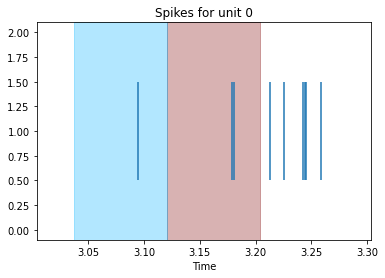

In [14]:
stim_id = 10
trial_id = stim_id_trial['phase'][stim_id][0]
unit_id = 0
t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
t0, t1 = t_off-0.2, t_off+0.1
stim_prev_id = trial_stim_id['phase'][trial_id-1]
t_prev_on, t_prev_off = stim['stim_ontime'][trial_id-1], stim['stim_offtime'][trial_id-1]
spikes = spike_times[unit_id][np.where((t0 < spike_times[unit_id]) & (spike_times[unit_id] < t1))]
plt.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
plt.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
plt.eventplot(spikes)
plt.xlim([t0, t1])
plt.title('Spikes for unit 0')
plt.xlabel('Time')
plt.show()

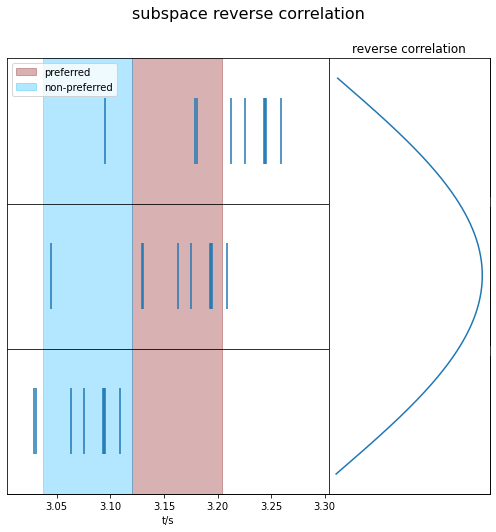

In [15]:
from matplotlib import gridspec

fig, ax = plt.subplots(3,1,figsize=(7,7))
gs0 = gridspec.GridSpec(3, 3, figure=fig, hspace=0, wspace=0)

stim_id = 10
trial_id = stim_id_trial['phase'][stim_id][0]
unit_id = 0
t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
t0, t1 = t_off-0.2, t_off+0.1
stim_prev_id = trial_stim_id['phase'][trial_id-1]
t_prev_on, t_prev_off = stim['stim_ontime'][trial_id-1], stim['stim_offtime'][trial_id-1]
spikes = spike_times[unit_id][np.where((t0 < spike_times[unit_id]) & (spike_times[unit_id] < t1))]

ax0 = fig.add_subplot(gs0[0, :-1])
ax1 = fig.add_subplot(gs0[1, :-1])
ax2 = fig.add_subplot(gs0[2, :-1])
ax3 = fig.add_subplot(gs0[:, -1])

ax0.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3, label='preferred')
ax0.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3, label='non-preferred')
ax0.eventplot(spikes)
ax0.set_xlim([t0, t1])
ax0.legend(loc='upper left')

ax1.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
ax1.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax1.eventplot(spikes-0.05)
ax1.set_xlim([t0, t1])

ax2.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
ax2.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax2.eventplot(spikes-0.15)
ax2.set_xlim([t0, t1])

ax3.plot(np.sin(np.pi*tau_id_range/300), np.arange(300))
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('reverse correlation')
# ax2.legend()
for ax in fig.get_axes():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

ax2.tick_params(bottom=True, labelbottom=True)
ax2.set_xlabel('t/s')
plt.tight_layout()
fig.suptitle('subspace reverse correlation', size=16, y=1.05)
plt.show()

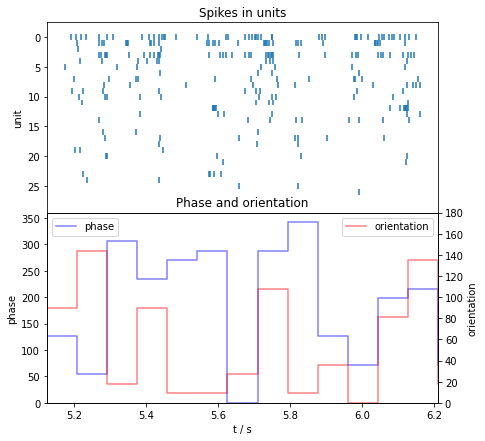

In [16]:
# subspace reverese correlation
stim_id = 13
ref_trial_id = stim_id_trial['phase'][stim_id][0]
stim_prev_id = trial_stim_id['phase'][ref_trial_id-1]
past_trials = 3
future_trials = 10
trial_range = np.arange(-past_trials, future_trials+1) + ref_trial_id

units = np.arange(num_unit)
orientation, phase, t_on = np.array(stim[['grat_orientation', 'grat_phase','stim_ontime']].iloc[trial_range]).T
spikes = [
    spike_times[unit_id][
        # Where the spike occurs during the stimulus period in one of the right trials
        np.where((t_on[0] < spike_times[unit_id]) & (spike_times[unit_id] < t_on[-1]))
        ]
    for unit_id in units]

fig, ax = plt.subplots(2,1,figsize=(7,7))
plt.subplots_adjust(hspace=0)
s = 1
ax[0].eventplot(spikes, linelength=s, lineoffsets=s)

ref_id = list(trial_range).index(ref_trial_id)
# ax[0].axvspan(t_on[ref_id], t_on[ref_id]+0.08, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
# ax[0].axvspan(t_on[ref_id-1], t_on[ref_id-1]+0.08, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax[0].set(ylabel='unit')
ax[0].invert_yaxis()
ax[1].step(t_on, phase, 'b', where='post', alpha=0.5, label='phase')
ax[1].set(xlabel='t / s', xlim=[t_on[0], t_on[-1]], ylim=[0, 360], ylabel='phase')
ax[1].legend(loc='upper left')
ax2 = ax[1].twinx()
ax2.step(t_on, orientation, 'r', where='post', alpha=0.5, label='orientation')
ax2.set(ylim=[0, 180], ylabel='orientation')
ax2.legend()
ax[0].set_title('Spikes in units')
ax[1].set_title('Phase and orientation')

plt.show()

In [17]:
@widgets.interact(key=widgets.RadioButtons(options=key_list[1:],
    description='stimulus:',
    disabled=False), tau_id=widgets.IntSlider(0, min=0, max=max_delay-1, description='delay/ms'), unit_id=widgets.IntSlider(0, min=0, max=num_unit-1))

def PSSH(tau_id, unit_id, key):
    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    prob = stim_hist[key][unit_id, tau_id]
    n = sorted_spike_num[unit_id]
    confidence_interval = np.sqrt(prob/n)
    plt.errorbar(stim_val[key], stim_hist[key][unit_id, tau_id], yerr=confidence_interval)
    ymin = np.min(stim_hist[key][unit_id])*0.95
    ymax = np.max(stim_hist[key][unit_id])*1.05
    ax.set_ylabel('$\mathcal{P}($'+key_symbol[key]+'$|\\tau)$')
    ax.set_xlabel(key_symbol[key])
    plt.ylim([ymin, ymax])
    plt.suptitle('Distribution of stimulus at time $\\tau$ before a spike of unit: %d'%unit_id)
    plt.show()

interactive(children=(IntSlider(value=0, description='delay/ms', max=299), IntSlider(value=0, description='uni…

##### Problem with the data

The picture a couple of cells below clearly shows that there is a shift in the stimulus presentation times. Let's fix it!

In [18]:
trial_spike_times = np.ndarray((num_unit, num_trial), dtype=object)
delta_t_on = 0.2 # 200ms
delta_t_off = 0.3
for trial_id in range(num_trial):
    t_on, t_off = stim['stim_ontime'][trial_id]-delta_t_on, stim['stim_offtime'][trial_id]+delta_t_off
    for unit_id in range(num_unit):
        trial_spike_times[unit_id, trial_id] = spike_times[unit_id][np.where((spike_times[unit_id] < t_off) & (spike_times[unit_id] > t_on))]
subseq_trials = 5
subseq_spike_times = np.ndarray(num_unit, dtype=object)
for unit_id in range(num_unit):
    subseq_spike_times[unit_id] = [np.concatenate(trial_spike_times[unit_id][i:i+subseq_trials]) for i in range(num_trial-subseq_trials)]

subseq_spike_times_locked = {}
subseq_spike_times_locked['ontime'] = [subseq_spike_times[unit_id] - stim['stim_ontime'][:-subseq_trials] for unit_id in range(num_unit)]
subseq_spike_times_locked['offtime'] = [subseq_spike_times[unit_id] - stim['stim_offtime'][:-subseq_trials]  for unit_id in range(num_unit)]

/usr/lib/python3.10/site-packages/pandas/core/roperator.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return right - left


In [19]:
time_range = np.arange(0, stim['stim_ontime'].max(), np.array(sorted(np.diff(stim['stim_ontime'], n=1))[10:-10]).mean())

In [20]:
subseq_spike_times_len = len(subseq_spike_times[0])
subseq_spike_times_locked['ontime'] = np.array(subseq_spike_times_locked['ontime'])
subseq_spike_times_locked['offtime'] = np.array(subseq_spike_times_locked['offtime'])
from itertools import chain
subseq_spike_times_locked['ontime'].shape, subseq_spike_times_locked['offtime'].shape, max(chain(*subseq_spike_times_locked['ontime'].flatten()))

((28, 19995), (28, 19995), 0.7671829999999886)

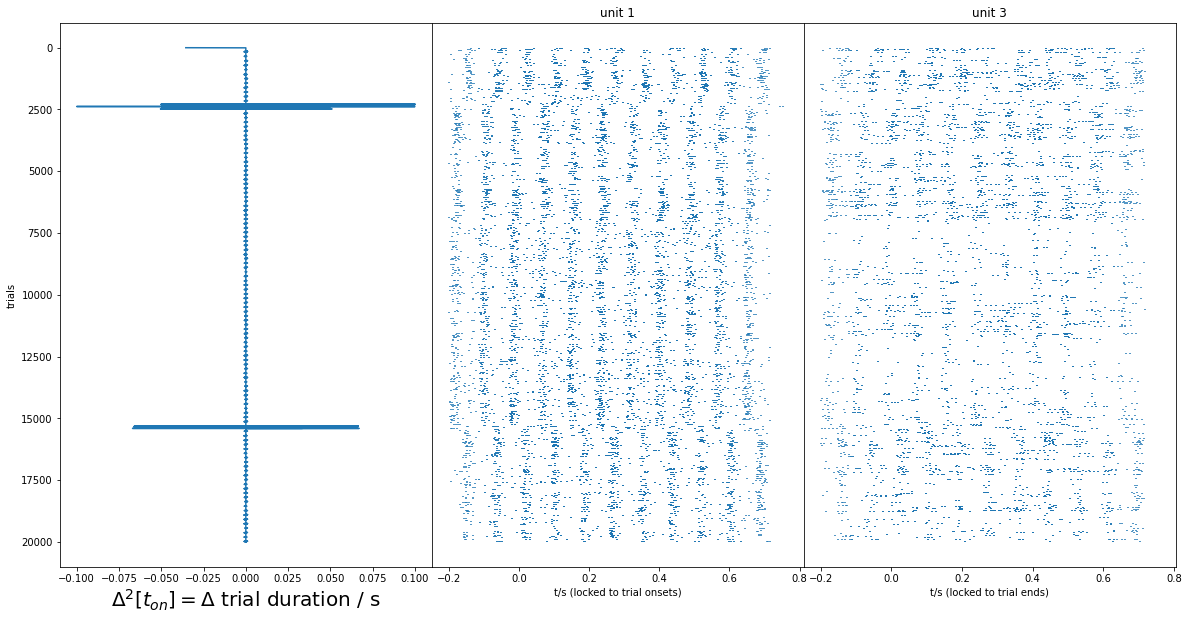

In [3]:
unit_id = 1
unit_id_2 = 3

fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].plot(np.diff(stim['stim_ontime'], n=2), np.arange(20000-2))
# ax[0].plot(stim['stim_ontime'] - stim['stim_offtime'], np.arange(20000))
ax[0].invert_yaxis()
ax[0].set_xlabel('$\Delta^2[t_{on}]=\Delta$ trial duration / s', size=20)
ax[0].set(ylabel='trials')
ax[1].eventplot(subseq_spike_times_locked['ontime'][unit_id], lineoffsets=1, linelengths=0.8)
ax[1].set(title='unit %d'%unit_id, yticks=[], xlabel='t/s (locked to trial onsets)')
ax[1].invert_yaxis()
ax[2].eventplot(subseq_spike_times_locked['ontime'][unit_id_2], lineoffsets=1, linelengths=0.8)
ax[2].set(title='unit %d'%(unit_id_2), yticks=[], xlabel='t/s (locked to trial ends)')
ax[2].invert_yaxis()
plt.subplots_adjust(wspace=0)
plt.show()

_Whaaat?_

Ok, we've gotta fix it.

Let's take the "bad" times, identify the periods we want to calibrate - and align everything

In [22]:
stim_2diffs = np.diff(stim['stim_ontime'], n=2)
print(*[i for i in range(len(stim_2diffs)) if stim_2diffs[i] > 0.01])

2280 2286 2291 2292 2295 2298 2301 2307 2377 2378 2380 2383 2386 2464 2467 2469 2472 2475 2478 15300 15306 15312 15315 15316 15318 15327 15329 15333 15336 15338 15342 15344 15348 15349 15402 15403 15405 15408


Periods:
$[0, 2350)$, $[2350, 15350)$, $[15350, 20000]$

In [23]:
p1, p2 = 2350, 15350
delta_t = 0.002
time_range_smoothing = np.arange(0, 0.8, delta_t)
period_1_dist = np.zeros(len(time_range_smoothing) - 1)
period_2_dist = np.zeros(len(time_range_smoothing) - 1)
period_3_dist = np.zeros(len(time_range_smoothing) - 1)
num_units = subseq_spike_times_locked['ontime'].shape[0]
for i in range(num_units):
    for j, row in enumerate(subseq_spike_times_locked['ontime'][i]):
        hist = np.histogram(row, bins=time_range_smoothing)[0]
        if j < p1:
            period_1_dist += hist
        elif j < p2:
            period_2_dist += hist
        else:
            period_3_dist += hist
period_1_dist /= num_units
period_2_dist /= num_units
period_3_dist /= num_units
period_1_dist = scipy.ndimage.filters.gaussian_filter1d(period_1_dist, sigma=10)
period_2_dist = scipy.ndimage.filters.gaussian_filter1d(period_2_dist, sigma=10)
period_3_dist = scipy.ndimage.filters.gaussian_filter1d(period_3_dist, sigma=10)

/tmp/ipykernel_4135643/175591453.py:20: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  period_1_dist = scipy.ndimage.filters.gaussian_filter1d(period_1_dist, sigma=10)
/tmp/ipykernel_4135643/175591453.py:21: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  period_2_dist = scipy.ndimage.filters.gaussian_filter1d(period_2_dist, sigma=10)
/tmp/ipykernel_4135643/175591453.py:22: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  period_3_dist = scipy.ndimage.filters.gaussian_filter1d(period_3_dist, sigma=10)


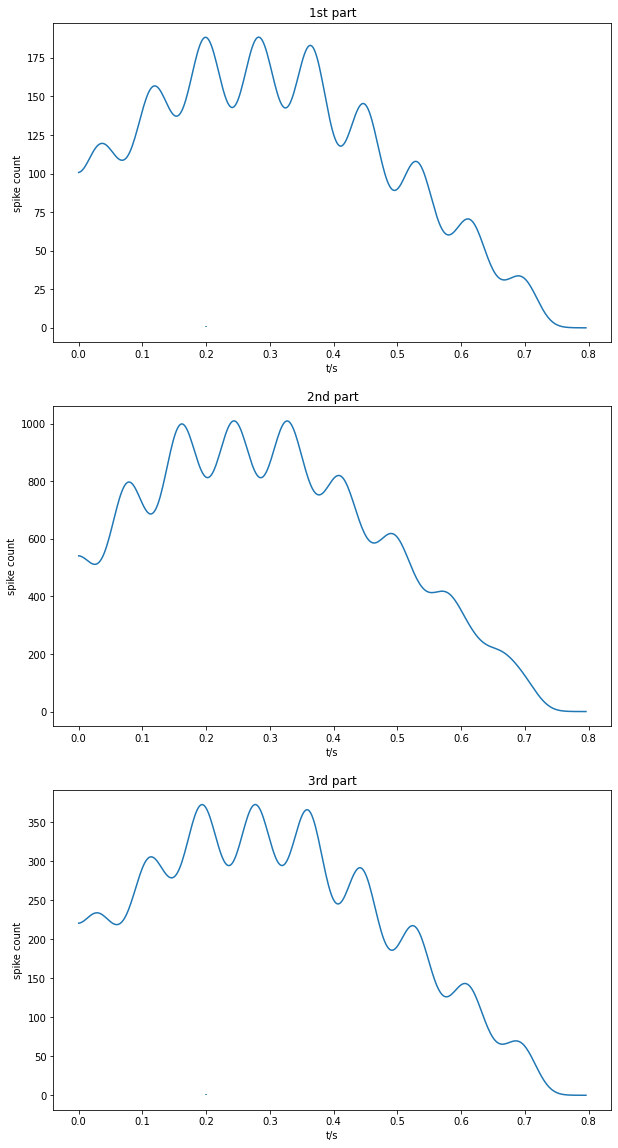

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(10,20))
ax[0].plot(time_range_smoothing[:-1], period_1_dist, label='period 1')
ax[1].plot(time_range_smoothing[:-1], period_2_dist, label='period 2')
ax[2].plot(time_range_smoothing[:-1], period_3_dist, label='period 3')
ax[0].set(xlabel='t/s', ylabel='spike count', title='1st part')
ax[1].set(xlabel='t/s', ylabel='spike count', title='2nd part')
ax[2].set(xlabel='t/s', ylabel='spike count', title='3rd part')
ax[0].eventplot([0.2], linelengths=0.8)
ax[1].eventplot([0.2], linelengths=0.8)
ax[2].eventplot([0.2], linelengths=0.8)

In [25]:
list(time_range_smoothing).index(0.2)

100

In [26]:
max_p_1 = time_range_smoothing[np.argmax(period_1_dist[:120])]
max_p_2 = time_range_smoothing[np.argmax(period_2_dist[:100])]
max_p_3 = time_range_smoothing[np.argmax(period_3_dist[:120])]
delta_2 = max_p_1 - max_p_2
delta_3 = max_p_1 - max_p_3
print(max_p_1, max_p_2, max_p_3)

0.2 0.162 0.194


Now we'll fix the times

In [10]:
t_p1, t_p2 = stim['stim_offtime'][p1], stim['stim_offtime'][p2]
fix_time = lambda t: t - delta_2 * ((t < t_p2) & (t >= t_p1)) - delta_3 * ((t >= t_p2))

In [28]:
fix_time(stim['stim_offtime'][:-subseq_trials])

0           2.5839
1           2.7028
2           2.7863
3           2.8699
4           2.9534
           ...    
19990    1671.6389
19991    1671.7224
19992    1671.8059
19993    1671.8894
19994    1671.9730
Name: stim_offtime, Length: 19995, dtype: float64

In [29]:
subseq_spike_times_locked_2 = {}
subseq_spike_times_locked_2['ontime'] = [subseq_spike_times[unit_id] - fix_time(stim['stim_ontime'][:-subseq_trials]) for unit_id in range(num_unit)]
subseq_spike_times_locked_2['offtime'] = [subseq_spike_times[unit_id] - fix_time(stim['stim_offtime'][:-subseq_trials])  for unit_id in range(num_unit)]

/usr/lib/python3.10/site-packages/pandas/core/roperator.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return right - left


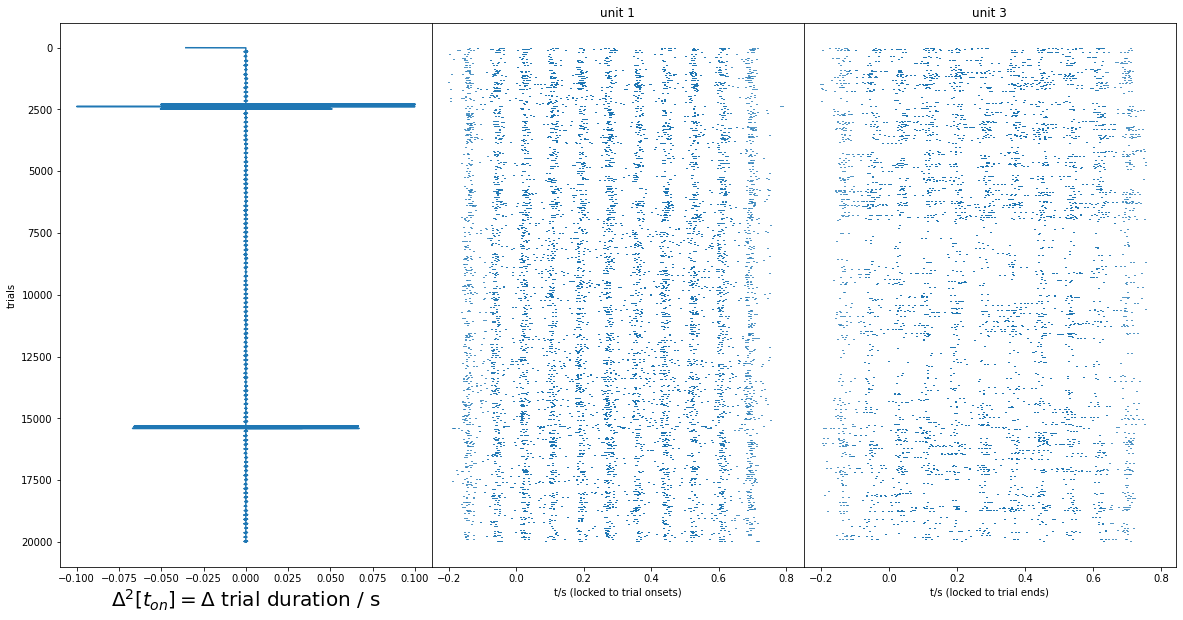

In [30]:
unit_id = 1

fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].plot(np.diff(stim['stim_ontime'], n=2), np.arange(20000-2))
ax[0].invert_yaxis()
ax[0].set_xlabel('$\Delta^2[t_{on}]=\Delta$ trial duration / s', size=20)
ax[0].set(ylabel='trials')
ax[1].eventplot(subseq_spike_times_locked_2['ontime'][unit_id], lineoffsets=1, linelengths=0.8)
ax[1].set(title='unit %d'%unit_id, yticks=[], xlabel='t/s (locked to trial onsets)')
ax[1].invert_yaxis()
ax[2].eventplot(subseq_spike_times_locked_2['ontime'][unit_id_2], lineoffsets=1, linelengths=0.8)
ax[2].set(title='unit %d'%(unit_id_2), yticks=[], xlabel='t/s (locked to trial ends)')
ax[2].invert_yaxis()
plt.subplots_adjust(wspace=0)
plt.show()

In [31]:
s = np.array([np.array(list(map(fix_time, spike_times[unit_id]))) for unit_id in range(len(spike_times))], dtype=object)//dt
B_spike_fixed = []
for unit_id in range(num_unit):
    B_spike_fixed.append(sparse.coo_matrix((np.ones(len(s[unit_id])), (np.zeros(len(s[unit_id]), dtype=int), np.int0(s[unit_id]))), shape=(1, M)))

In [32]:
from copy import deepcopy
B_stim_original = deepcopy(B_stim)

In [33]:
B_stim = {}
for key in key_list:
    B_stim[key] = []
    for stim_id, trials in enumerate(stim_id_trial[key]):
        B_stim[key].append([])
        s = []
        for trial_id in trials:
            t_on, t_off = fix_time(stim['stim_ontime'][trial_id]), fix_time(stim['stim_offtime'][trial_id])
            s += list(np.arange(int(t_on//dt), int(t_off//dt)))

        B_stim[key][stim_id] = sparse.coo_matrix((np.ones(len(s)), (np.zeros(len(s), dtype=int), s)), shape=(1, M))

#### Calculate some matrices

In [8]:
get_trial_index = lambda t: fix_time(stim['stim_ontime'][t])//dt

In [43]:
B_spike_smooth = list()
for unit_id in range(len(B_spike)):
    B_spike_smooth.append(scipy.ndimage.gaussian_filter(B_spike[unit_id].toarray()[0], sigma=50))
B_spike_smooth = np.array(B_spike_smooth)

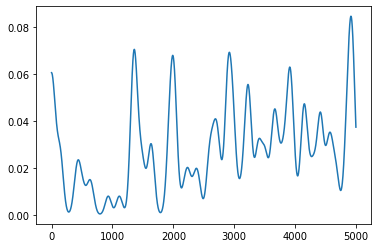

In [36]:
plt.plot(B_spike_smooth[0][:5000])  # ~10 trials

##### Reverse correlation

TL;DR: We find the reverse correlation matrices. When we plot them they look meh, but if we plot them smoothed, they look awesome. However, we shouldn't use this smoothing when decoding parameters because it uses our (parameter-defined) notion of distance between points.

In [42]:
B_stim_total = np.sum(B_stim['phase'])

In [100]:
R = dict()
for key in key_list:
    R[key] = list()
    for i in range(len(B_stim[key])):
        item = []
        for u in range(len(B_spike_smooth)):
            item.append(B_stim[key][i].dot(np.roll(B_spike_smooth[u], 80)))
        R[key].append(item)
    R[key] = np.array(R[key])

In [104]:
R['pair'] = R['pair'].reshape((20, 20, 40))
Rp = R['pair']

In [102]:
R_pair_smoothed = np.array([scipy.ndimage.gaussian_filter(R['pair'][:, :, i], sigma=2) for i in range(40)])

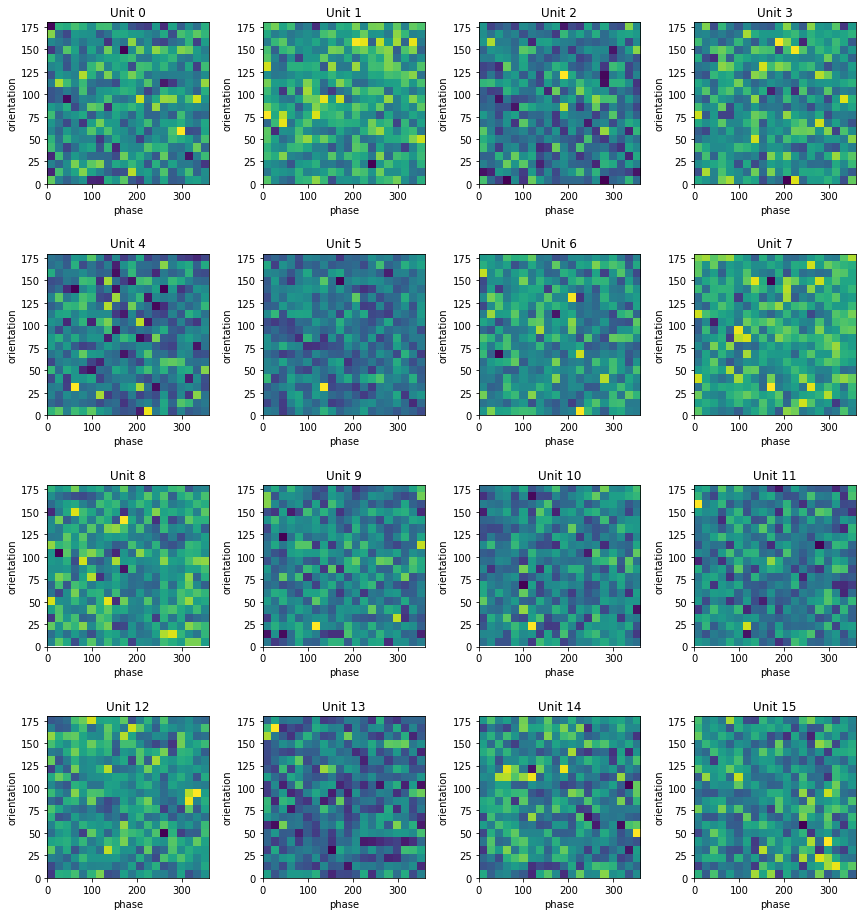

In [103]:
fig, axs = plt.subplots(4, 4, figsize=(12, 13))
fig.tight_layout(w_pad=2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(R['pair'][:, :, i], extent=(0, 360, 0, 180), aspect=2)
    ax.set(xlabel="phase", ylabel="orientation", title=f"Unit {i}")

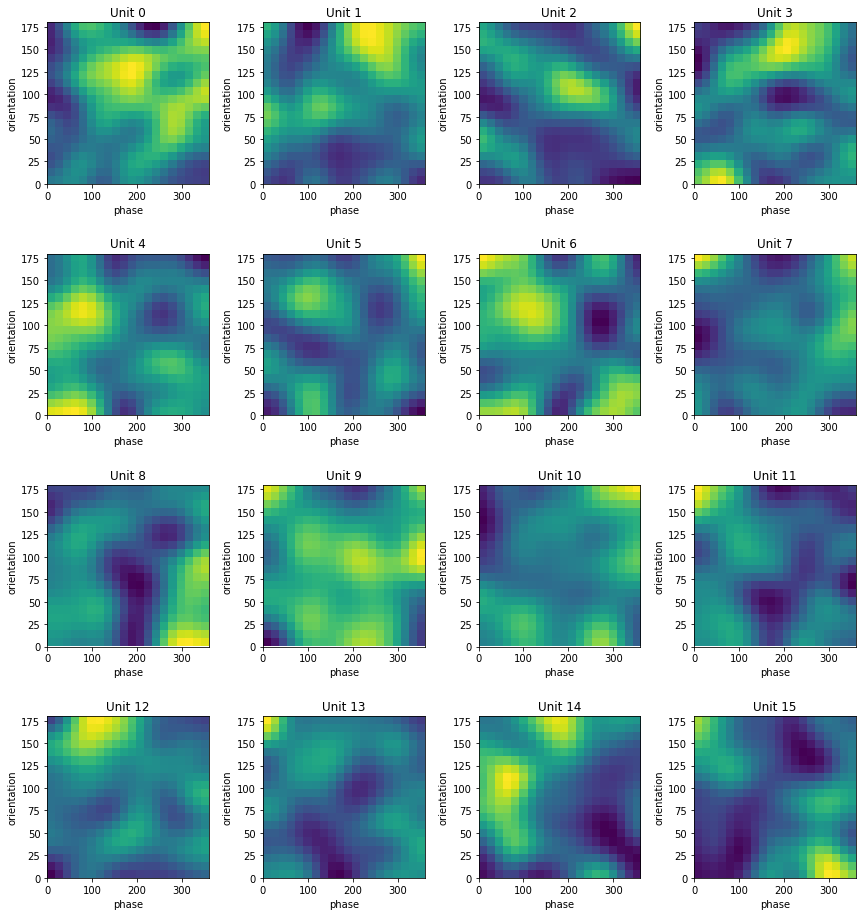

In [98]:
fig, axs = plt.subplots(4, 4, figsize=(12, 13))
fig.tight_layout(w_pad=2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(R_pair_smoothed[i], extent=(0, 360, 0, 180), aspect=2)
    ax.set(xlabel="phase", ylabel="orientation", title=f"Unit {i}")

In [113]:
res = top_noise_reduction(pd.DataFrame(Rp.reshape((400, 40)))).to_numpy()

Topological noise reduction: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


In [121]:
res[0][0]

128.81601674915015

##### Intermission: save variables to a file

In [132]:
import pickle
with open('dump.pkl', 'wb') as f:
    pickle.dump({k: globals()[k] for k in [
        'data_folder', 'stim_file', 'spike_times_file', 'key_symbol', 
        'stim', 'num_trial', 'stim_val', 'trial_stim_id', 'key_list', 'stim_id_trial', 'num_stim', 'key', 'pair_id', 'trial_pair_id', 'pair_val', 'pair_trial_id',
        'spike_times', 'num_unit', 'num_spike', 'spike_count_rate', 'avg_firing_rate', 'firing_rate', 'stim_num_trial', 'stim_hist', 'optimal_avg_firing_rate',
        'latest_spike_time', 'dt', 'exp_time', 'B_stim', 'trials', 't_on', 't_off', 'B_spike', 'trial_range', 'units', 'orientation', 'phase', 'trial_spike_times',
        'delta_t_on', 'delta_t_off', 'subseq_trials', 'subseq_spike_times', 'subseq_spike_times_locked', 'time_range', 'unit_id_2', 'p1', 'p2', 'delta_t', 'time_range_smoothing',
        'period_1_dist', 'period_2_dist', 'period_3_dist', 'num_units', 'max_p_1', 'max_p_2', 'max_p_3', 'delta_2', 'delta_3', 't_p1', 't_p2', 'subseq_spike_times_locked_2',
        'B_spike_fixed', 'B_stim_original', 'B_spike_smooth', 'B_stim_total', 'R', 'R_pair_smoothed', 'Rp'
        ]}, f)

In [12]:
file = open("dump.pkl", 'rb')
data = pkl.load(file)
print(data.keys())
for key, value in data.items():
    globals()[key] = value
file.close()

dict_keys(['data_folder', 'stim_file', 'spike_times_file', 'key_symbol', 'stim', 'num_trial', 'stim_val', 'trial_stim_id', 'key_list', 'stim_id_trial', 'num_stim', 'key', 'pair_id', 'trial_pair_id', 'pair_val', 'pair_trial_id', 'spike_times', 'num_unit', 'num_spike', 'spike_count_rate', 'avg_firing_rate', 'firing_rate', 'stim_num_trial', 'stim_hist', 'optimal_avg_firing_rate', 'latest_spike_time', 'dt', 'exp_time', 'B_stim', 'trials', 't_on', 't_off', 'B_spike', 'trial_range', 'units', 'orientation', 'phase', 'trial_spike_times', 'delta_t_on', 'delta_t_off', 'subseq_trials', 'subseq_spike_times', 'subseq_spike_times_locked', 'time_range', 'unit_id_2', 'p1', 'p2', 'delta_t', 'time_range_smoothing', 'period_1_dist', 'period_2_dist', 'period_3_dist', 'num_units', 'max_p_1', 'max_p_2', 'max_p_3', 'delta_2', 'delta_3', 't_p1', 't_p2', 'subseq_spike_times_locked_2', 'B_spike_fixed', 'B_stim_original', 'B_spike_smooth', 'B_stim_total', 'R', 'R_pair_smoothed', 'Rp', 'firing_rates_noise_red', '

In [131]:
print(*globals().keys())

__name__ __doc__ __package__ __loader__ __spec__ __builtin__ __builtins__ _ih _oh _dh In Out get_ipython exit quit _ __ ___ os sys __vsc_ipynb_file__ _i _ii _iii _i1 np plt pd scipy sts pkl widgets mplot3d Axes3D sparse cm cmap_hot cmap_viridis cmap_jet _i2 data_folder stim_file spike_times_file key_symbol _i3 stim num_trial stim_val trial_stim_id key_list stim_id_trial num_stim key pair_id trial_pair_id pair_val pair_trial_id i _i4 _4 _i5 _i6 _i7 _7 _i8 spike_times active num_unit _8 _i9 num_spike _i10 files file_name file data value spike_count_rate avg_firing_rate sem_firing_rate firing_rate stim_num_trial C_r_fphi_theta theta_hist phase_hist pair_hist corr_stim_unit optimal_avg_firing_rate stim_hist stim_hist_caution _i11 max_delay tau_id_range latest_spike_time latest_stim_offtime experiment_dur dt exp_time M _i12 B_stim stim_id trials s trial_id t_on t_off B_spike unit_id _i13 sorted_spike_num cutoff_num_spike _i14 t0 t1 stim_prev_id t_prev_on t_prev_off spikes _i15 gridspec fig 

##### Forward correlation

In [11]:
firing_rates_in_trials = []   # by pair, then by trial, then by neuron
firing_rates_flat = []

for trial_ids in stim_id_trial['pair']:
    row = []
    for trial_id in trial_ids:
        ind = round(get_trial_index(trial_id))
        rr = []
        for u in range(len(B_spike_smooth)):
            rr.append(np.mean(B_spike_smooth[u][ind + 50:ind + 90]))
        row.append(np.array(rr))
        firing_rates_flat.append(np.array(rr))
    firing_rates_in_trials.append(np.array(row))

In [12]:
firing_rates_flat = np.array(firing_rates_flat)
len(firing_rates_in_trials), firing_rates_in_trials[0].shape

(400, (50, 40))

In [13]:
avg_firing_rates = np.array([np.mean(fr_pair, axis=0) for fr_pair in firing_rates_in_trials]).reshape((20, 20, 40))

In [32]:
avg_firing_rates = np.random.uniform(size=(20, 20, 40))

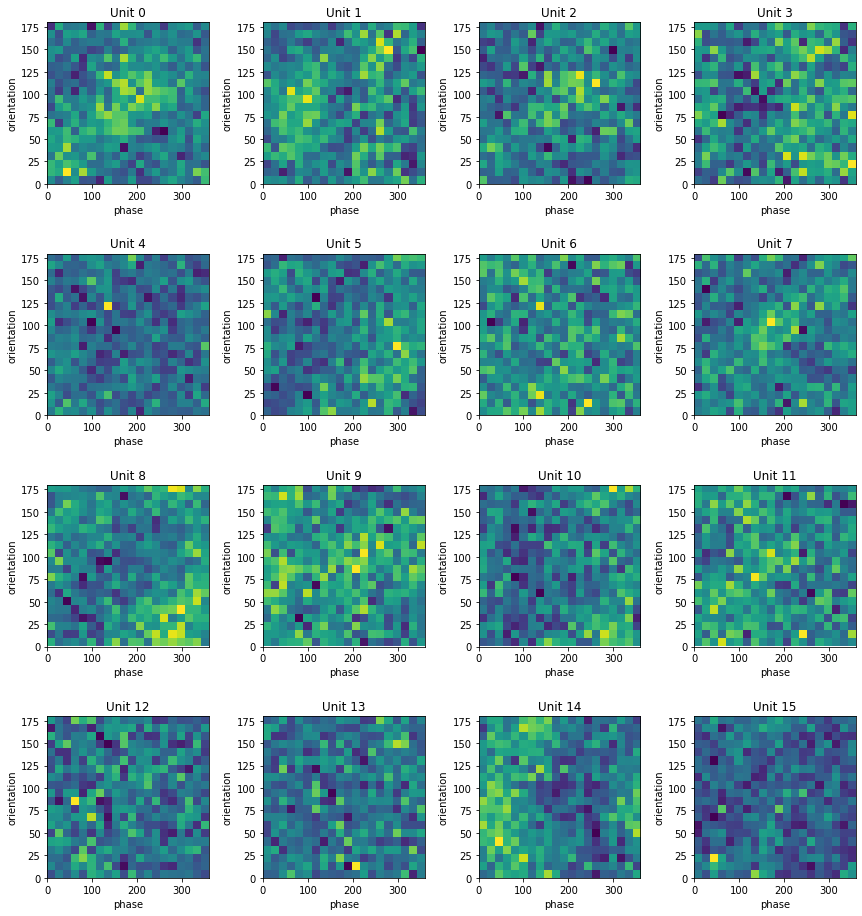

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(12, 13))
fig.tight_layout(w_pad=2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_firing_rates[:, :, i], extent=(0, 360, 0, 180), aspect=2)
    ax.set(xlabel="phase", ylabel="orientation", title=f"Unit {i}")

Gauss

In [5]:
G_PAD = 5

def gauss(img):
    img_vpad = np.concatenate((img[-G_PAD:][:, ::-1], img, img[:G_PAD][:, ::-1]))
    # pad horizontally too
    img_vhpad = np.concatenate((img_vpad[:, -G_PAD:], img_vpad, img_vpad[:, :G_PAD]), axis=1)
    return scipy.ndimage.gaussian_filter(img_vhpad, sigma=2, mode='wrap')[G_PAD:-G_PAD, G_PAD:-G_PAD]

In [6]:
avg_fr_blur = np.array([gauss(avg_firing_rates[:, :, i]) for i in range(40)])
gauss(avg_firing_rates[:, :, 0]).shape

(20, 20)

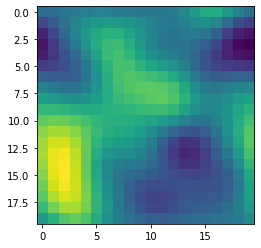

In [7]:
plt.imshow(avg_fr_blur.mean(axis=0))

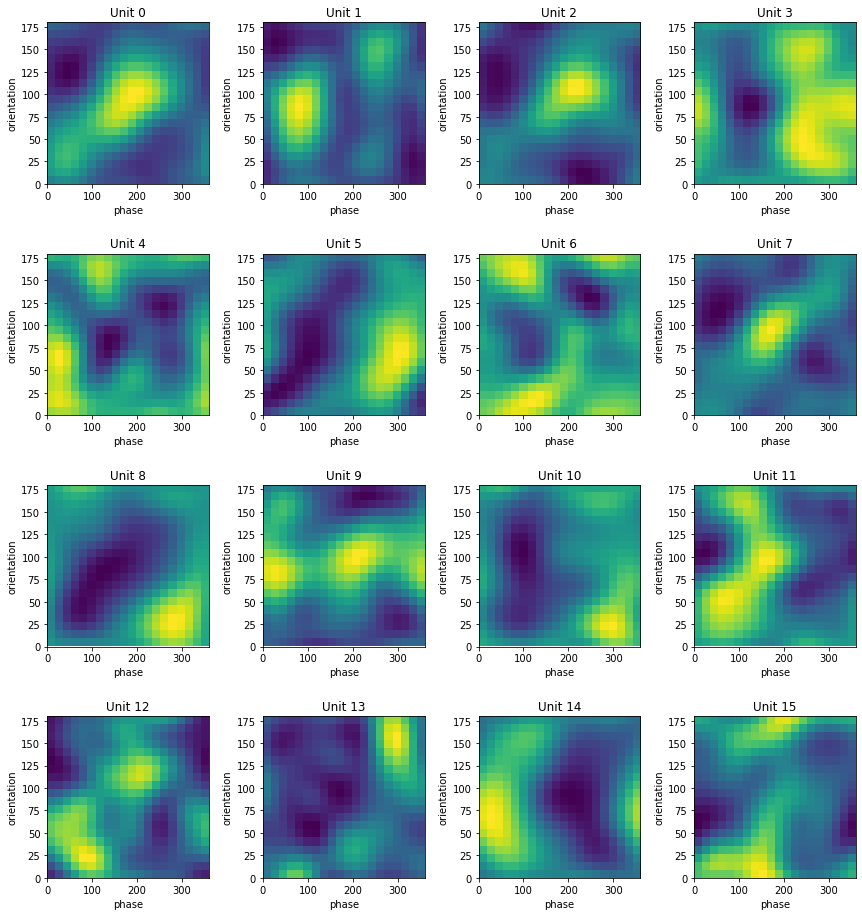

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(12, 13))
fig.tight_layout(w_pad=2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_fr_blur[i], extent=(0, 360, 0, 180), aspect=2)
    ax.set(xlabel="phase", ylabel="orientation", title=f"Unit {i}")
avg_fr_blur = avg_fr_blur.swapaxes(0, 2).reshape((400, 40))

In [40]:
stim_val['orientation']

array([  0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,
        99., 108., 117., 126., 135., 144., 153., 162., 171.])

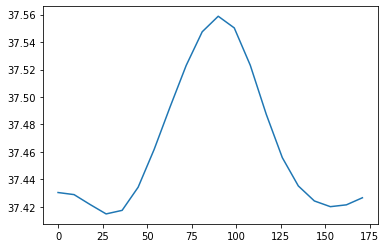

In [41]:
%matplotlib inline
from sym_model import sigmoid
# sns.distplot([np.argmax(avg_fr_blur.reshape((20, 20, 40))[:, :, i], axis=0) for i in range(40)])
# plt.imshow(sigmoid(avg_fr_blur * 10000).reshape((20, 20, 40)).sum(axis=2), extent=(0, 360, 0, 180), aspect=2)
plt.plot(stim_val['orientation'], sigmoid(avg_fr_blur * 10000).reshape((20, 20, 40)).sum(axis=2).mean(axis=1))

##### Topological noise reduction (not used)

In [109]:
import sys
sys.path.insert(0, '../model')
from noisereduction import top_noise_reduction

In [149]:
firing_rates_noise_red = top_noise_reduction(pd.DataFrame(firing_rates_flat[::5]))

Topological noise reduction: 100%|██████████| 100/100 [31:33<00:00, 18.93s/it]


In [150]:
firing_rates_noise_red.shape

(400, 40)

In [151]:
firing_rates_noise_red = top_noise_reduction(pd.DataFrame(firing_rates_flat))

Topological noise reduction: 100%|██████████| 100/100 [3:44:17<00:00, 134.57s/it] 


In [166]:
firing_rates_noise_red = firing_rates_noise_red.to_numpy()
firing_rates_noise_red.shape

(2000, 40)

In [167]:
firing_rates_noise_red[0] in firing_rates_flat

False

In [168]:
from decoding import cohomological_parameterization

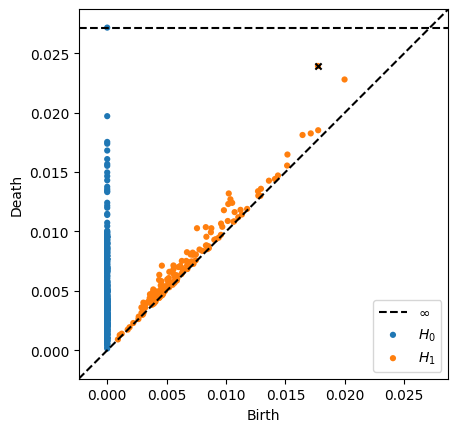

Decoding... done


In [171]:
param = cohomological_parameterization(pd.DataFrame(firing_rates_noise_red[::5, ::5]))

##### PCA

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns

<AxesSubplot:>

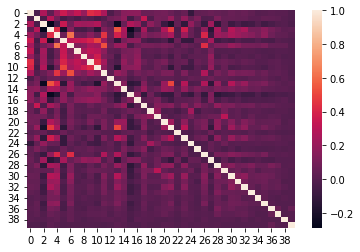

In [9]:
fr_df = pd.DataFrame(firing_rates_flat)
sns.heatmap(fr_df.corr())

In [10]:
avg_fr_blur.shape

(400, 40)

In [8]:
N_COMP = 7
pca = PCA(n_components=N_COMP)
pca.fit(avg_fr_blur)
data_pca = pca.transform(avg_fr_blur)
data_pca = pd.DataFrame(data_pca)
print(data_pca.shape)
data_pca.head()

(400, 7)


0         1         2         3         4         5         6
0 -0.000519 -0.000166 -0.000440 -0.000621  0.000040  0.000021  0.000077
1 -0.000851 -0.000060 -0.000512 -0.000473  0.000343  0.000135  0.000052
2 -0.001155  0.000042 -0.000481 -0.000354  0.000566  0.000213  0.000038
3 -0.001385  0.000152 -0.000368 -0.000247  0.000665  0.000252  0.000033
4 -0.001536  0.000289 -0.000196 -0.000120  0.000648  0.000248  0.000016

In [50]:
firing_rates_in_trials_pca = []
for trials in firing_rates_in_trials:
    firing_rates_in_trials_pca.append(pca.transform(pd.DataFrame(trials)))
firing_rates_in_trials_pca = np.array(firing_rates_in_trials_pca)
firing_rates_in_trials_pca.shape

(400, 50, 7)

In [9]:
avg_firing_rates_pca = data_pca.to_numpy().reshape((20, 20, N_COMP))# np.mean(firing_rates_in_trials_pca, axis=1).reshape((20, 20, N_COMP))

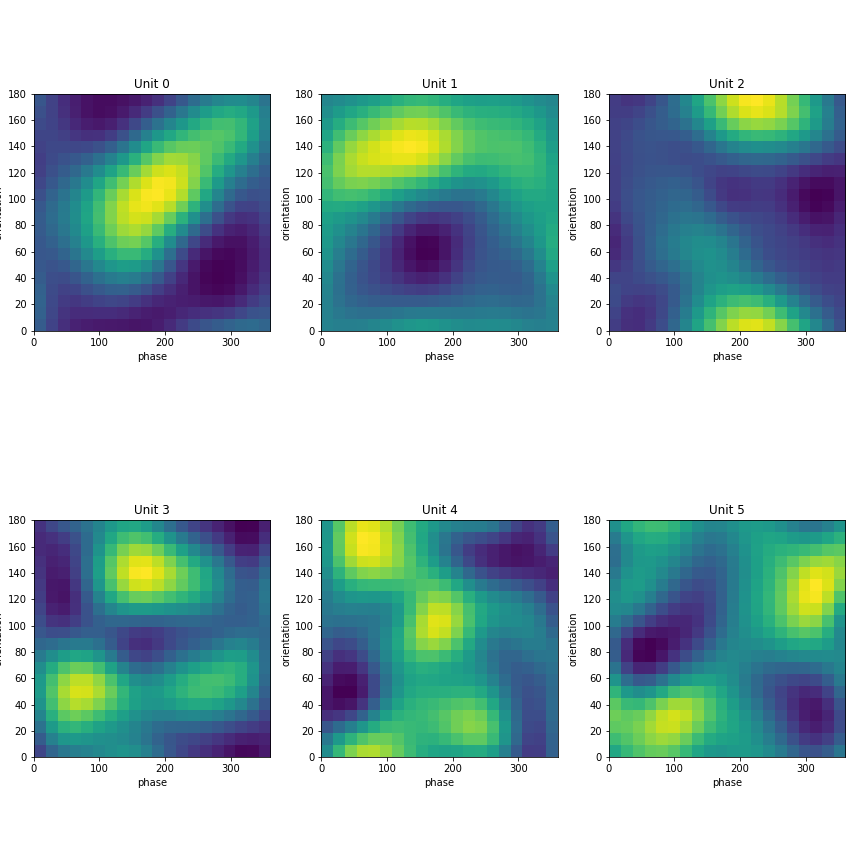

In [14]:

fig, axs = plt.subplots(2, 3, figsize=(12, 12))
fig.tight_layout(w_pad=2)
for i, ax in enumerate(axs.flatten()[:7]):
    ax.imshow(avg_firing_rates_pca[:, :, i], extent=(0, 360, 0, 180), aspect=2)
    ax.set(xlabel="phase", ylabel="orientation", title=f"Unit {i}")

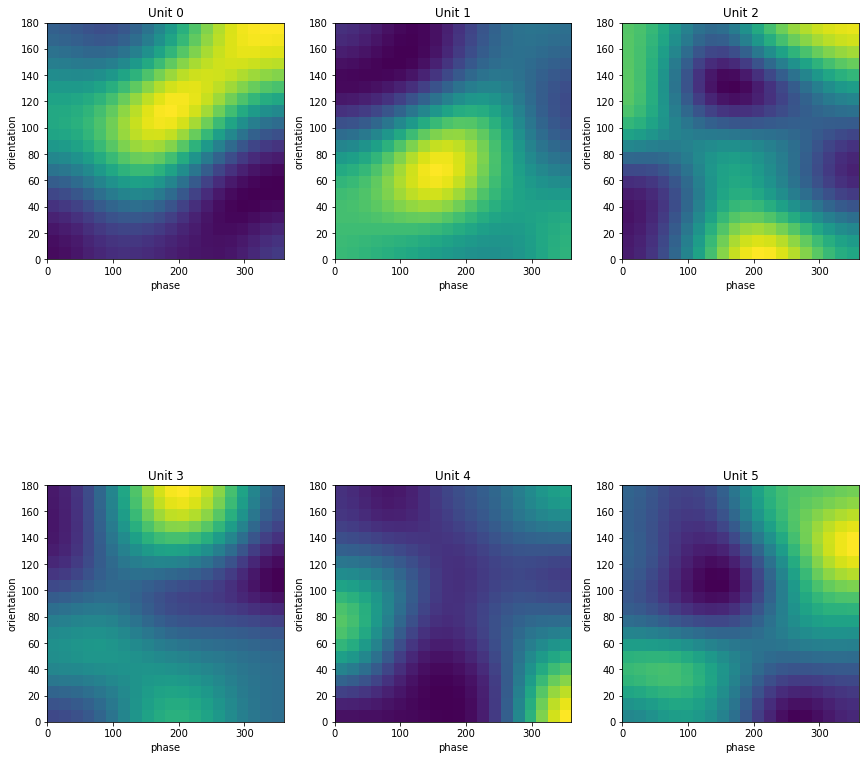

In [12]:

fig, axs = plt.subplots(2, 3, figsize=(12, 13))
fig.tight_layout(w_pad=2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(scipy.ndimage.gaussian_filter(avg_firing_rates_pca[:, :, i], sigma=2), extent=(0, 360, 0, 180), aspect=2)
    ax.set(xlabel="phase", ylabel="orientation", title=f"Unit {i}")

##### Point Cloud Simplification

In [52]:
def radial_distance(X, eps, random_state=None):
    """
    point cloud simplification using radial distance (euclidean metric). 
    Start with the first point in in X and mark it as a key point. All consecutive points that have a distance less than a predetermined distance eps to the key point are removed. The first point that have a distance greater than eps to the key point is marked as the new key point. The process repeates itself from this new key point, and continues until it reaches the end of the point cloud.
    
    Parameters
    ----------
    X: pandas DataFrame (n_datapoints, n_features):

    eps: max radial distance - cutoff distance

    random_state: seed of random generator used for choosing the inital point

    Returns
    -------
    X.iloc[ind_reduced]: dataframe with chosen datapoints 
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    ix0 = np.random.choice(X.shape[0])
    x0 = X.iloc[ix0]
    xt = x0
    ixt = ix0
    X_temp = X
    ind_reduced = [ix0]

    while True:
        dist = np.linalg.norm(X_temp.to_numpy() - xt.to_numpy(), axis=1)
        cond = dist < eps

        X_temp = X_temp.drop(X_temp.index[np.where(cond)])
        if len(X_temp)==0:
            break

        where_not_cond = np.where(np.logical_not(cond))
        w = np.argmin(dist[where_not_cond])        
        ixt = X_temp.index[w]
        xt = X.iloc[ixt]
        ind_reduced.append(ixt)

    return X.iloc[ind_reduced], ind_reduced   


In [107]:
from tqdm import trange
from noisereduction import compute_gradient
def top_noise_reduction(X, n=100, omega=0.2, fraction=0.1, plot=False):
    """
    Topological denoising algorithm as in arxiv:0910.5947
    
    Parameters
    ----------
    X: dataframe(n_datapoints, n_features):
        Dataframe containing the data
    n: int, optional, default 100
        Number of iterations
    omega: float, optional, default 0.2
        Strength of the repulsive force between datapoints
    fraction: float between 0 and 1, optional, default 0.1
        The fraction of datapoints from which the denoised dataset is
        constructed
    plot: bool, optional, default False
        When true plot the dataset and homology each iteration
    """
    N = X.shape[0]
    inds = np.random.choice(N, round(fraction*N), replace=False)
    S = X.iloc[inds]
    sigma = X.stack().std()
    c = 0.02*np.max(scipy.spatial.distance.cdist(X, X, metric='euclidean'))
    
    iterator = trange(0, n, position=0, leave=True)
    iterator.set_description("Topological noise reduction")
    for i in iterator:
        gradF = compute_gradient(S.to_numpy(), X.to_numpy(), sigma, omega)
            
        if i == 0:
            maxgradF = np.max(np.sqrt(np.square(gradF).sum(axis=1)))
        S = S + c* gradF/maxgradF
        
        if plot:
            fig = pyplot.figure()
            ax = Axes3D(fig)
            ax.scatter(X[0],X[1],X[2],alpha=0.1)
            ax.scatter(S[0],S[1],S[2])
            pyplot.show()
    return S, inds

In [127]:
fr_pca_simpl, inds_simpl = radial_distance(pd.DataFrame(firing_rates_in_trials_pca.reshape((400 * 50, -1))), 0.025)
fr_pca_simpl.shape

(414, 7)

##### Plots

In [12]:
param_corr = stim_val['pair']  # [np.array(inds_simpl) // 50]
param_corr.shape

(400, 2)

In [10]:
avg_firing_rates_pca_ = avg_firing_rates_pca.reshape((-1, N_COMP))

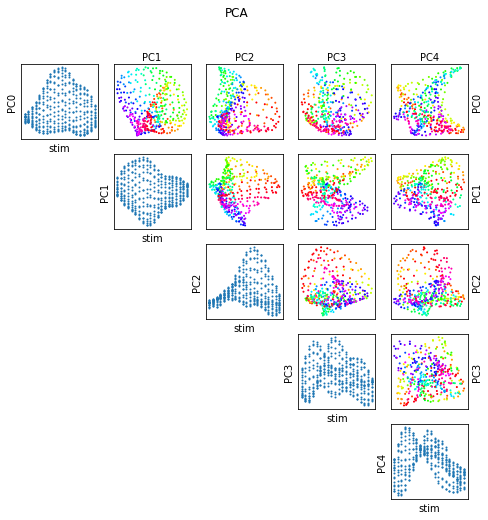

In [15]:
%matplotlib inline
ncomp_disp = 5
fig = plt.figure(figsize=(8,8))
for j in range(ncomp_disp):
  for i in range(j+1):
    ax = fig.add_subplot(ncomp_disp,ncomp_disp, j + ncomp_disp*i + 1)
    if i == j:
      ax.scatter(
        # param_corr[:, 0],
        stim_val['pair'].reshape((-1, 2))[:, 1],
        avg_firing_rates_pca_[:, i], s=1)
      ax.set(xlabel='stim', ylabel='PC%d'%i)
    else:
      ax.scatter(avg_firing_rates_pca_[:, j], avg_firing_rates_pca_[:, i], s=1, c=stim_val['pair'].reshape((-1, 2))[:, 0], cmap='hsv')
    
    ax.set(xticks=[], yticks=[])
    
    if i==0 and j>0:
      ax.set(xlabel='PC%d'%j)
      ax.xaxis.set_label_position('top') 

    if j==ncomp_disp-1 and i<ncomp_disp-1:
      ax.set(ylabel='PC%d'%i)
      ax.yaxis.set_label_position('right') 

fig.set_facecolor('white')
fig.suptitle('PCA')
plt.show()

##### UMAP

In [11]:
from umap import UMAP

/usr/lib/python3.10/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'awkward._connect._numba' failed to load due to 'AttributeError(module 'setuptools' has no attribute 'extern')'.
  numba.core.entrypoints.init_all()


In [12]:
ncomp_umap = 4
embed = UMAP(n_components=ncomp_umap, n_neighbors=10, metric='euclidean').fit_transform(avg_firing_rates_pca_)

In [ ]:
param_corr[:, 0].max()

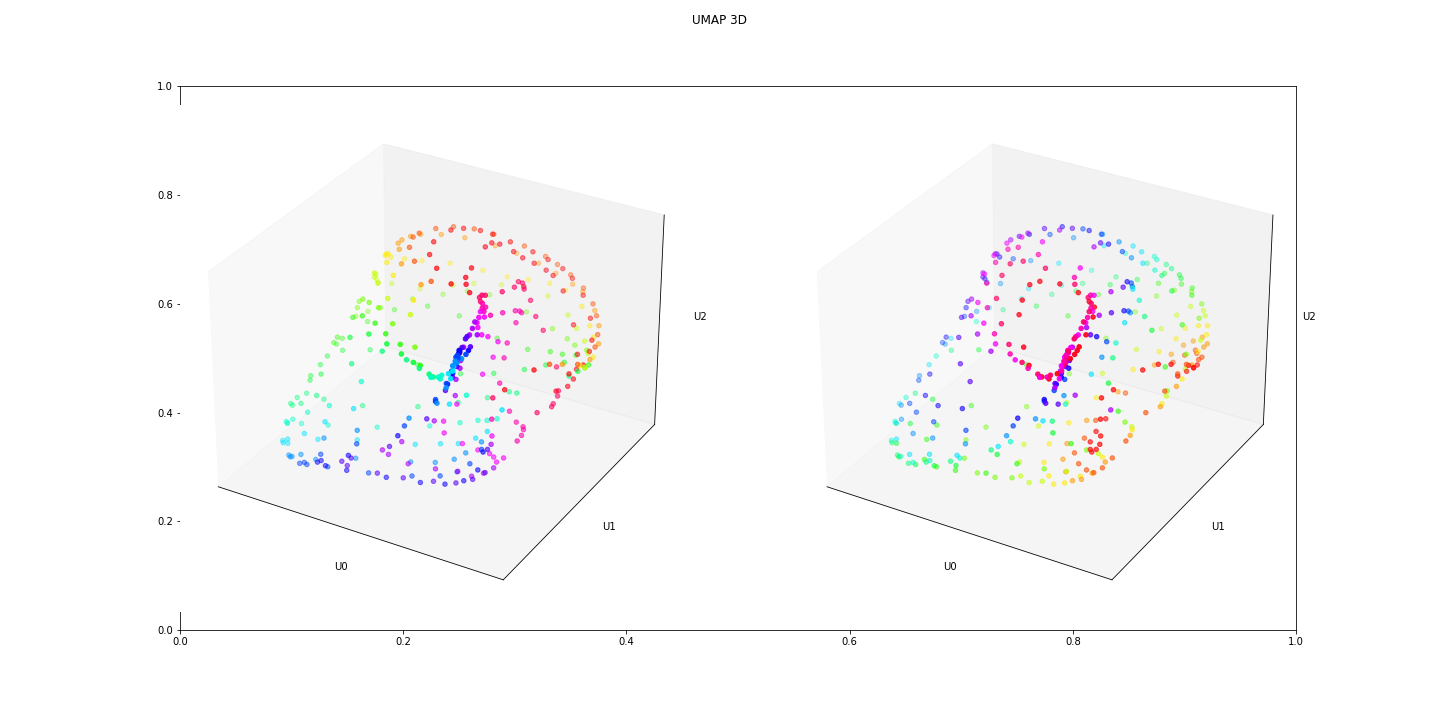

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.8333333134651184, 'type': 'set_device_pixel_ratio'}


In [13]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%matplotlib widget

x, y, z, u = embed[:,0], embed[:,1], embed[:,2], embed[:,3]    

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ax.scatter3D(x, y, z, c=np.array([param_corr[:, 0] / 180, [0] * param_corr.shape[0], param_corr[:, 1] / 360]).swapaxes(0, 1))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(x, y, z, c=param_corr[:, 0], cmap="hsv")
ax.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(x, y, z, c=param_corr[:, 1], cmap="hsv")
ax.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[])
# ax = fig.add_subplot(2, 2, 3, projection='3d')
# ax.scatter3D(x, y, u, c=param_corr[:, 0], cmap="hsv")
# ax.set(xlabel="U0", ylabel="U1", zlabel="U3", xticks=[], yticks=[], zticks=[])
# ax = fig.add_subplot(2, 2, 4, projection='3d')
# ax.scatter3D(x, y, u, c=param_corr[:, 1], cmap="hsv")
# ax.set(xlabel="U0", ylabel="U1", zlabel="U3", xticks=[], yticks=[], zticks=[])
fig.suptitle('UMAP 3D')
plt.show()

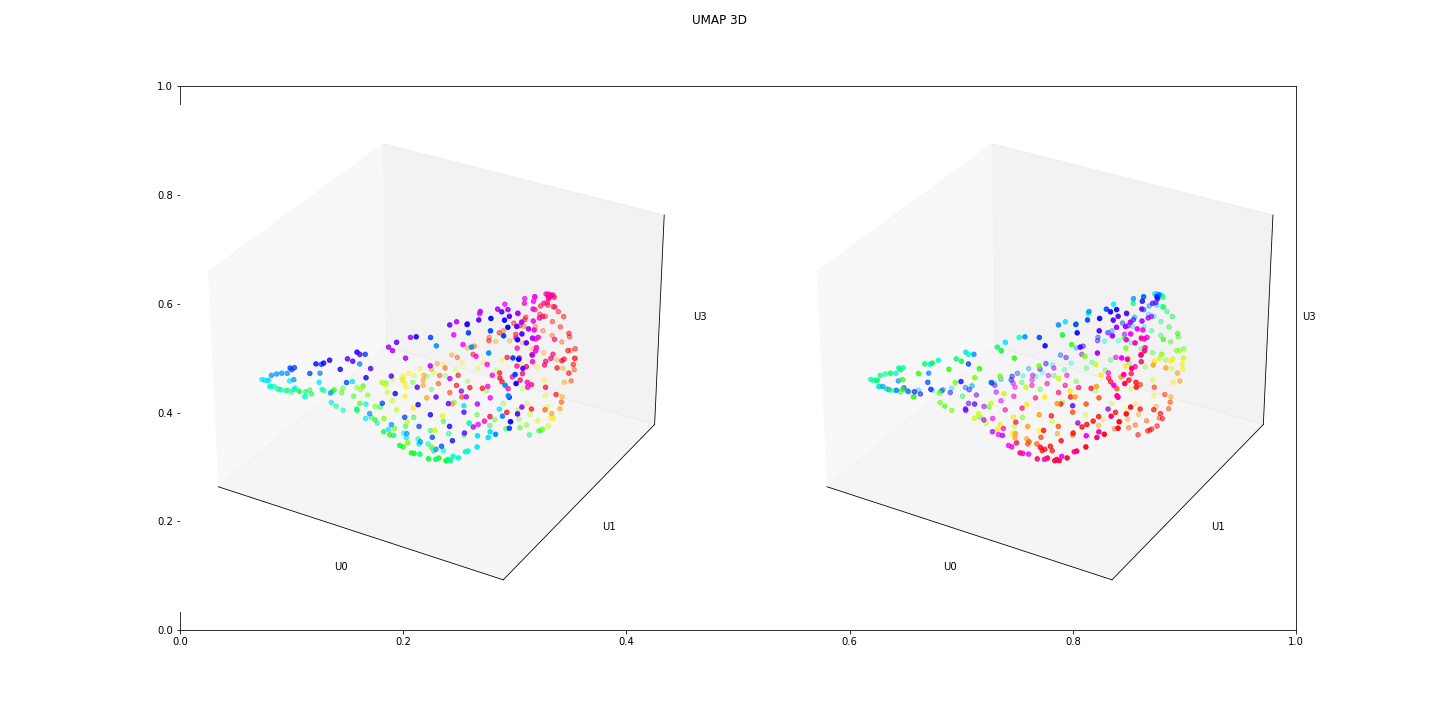

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ax.scatter3D(x, y, z, c=np.array([param_corr[:, 0] / 180, [0] * param_corr.shape[0], param_corr[:, 1] / 360]).swapaxes(0, 1))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(x, y, u, c=param_corr[:, 0], cmap="hsv")
ax.set(xlabel="U0", ylabel="U1", zlabel="U3", xticks=[], yticks=[], zticks=[])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(x, y, u, c=param_corr[:, 1], cmap="hsv")
ax.set(xlabel="U0", ylabel="U1", zlabel="U3", xticks=[], yticks=[], zticks=[])

fig.suptitle('UMAP 3D')
plt.show()

In [41]:
embed_rnd = embed

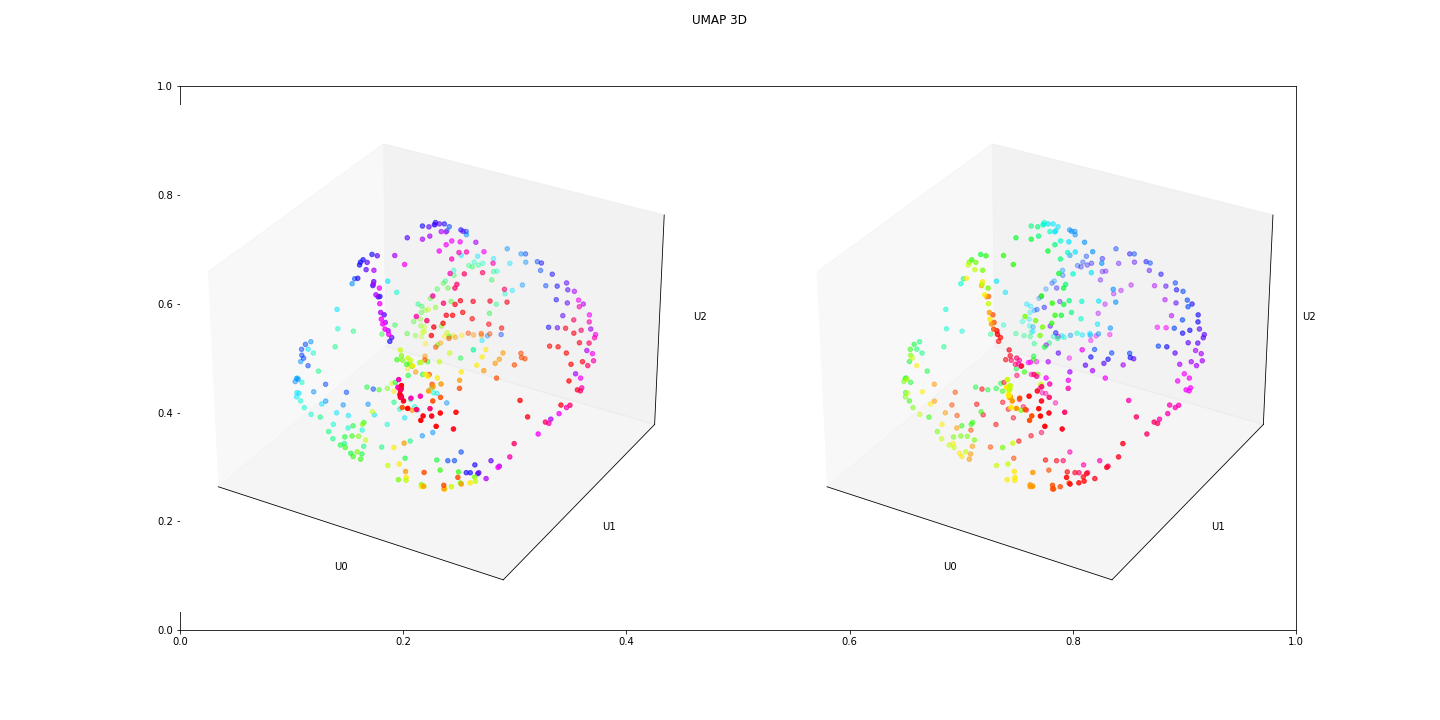

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.8333333134651184, 'type': 'set_device_pixel_ratio'}


In [51]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%matplotlib widget

x, y, z, u = embed_rnd[:,0], embed_rnd[:,1], embed_rnd[:,2], embed_rnd[:,3]    

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ax.scatter3D(x, y, z, c=np.array([param_corr[:, 0] / 180, [0] * param_corr.shape[0], param_corr[:, 1] / 360]).swapaxes(0, 1))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(x, y, z, c=param_corr[:, 0], cmap="hsv")
ax.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(x, y, z, c=param_corr[:, 1], cmap="hsv")
ax.set(xlabel="U0", ylabel="U1", zlabel="U2", xticks=[], yticks=[], zticks=[])
# ax = fig.add_subplot(2, 2, 3, projection='3d')
# ax.scatter3D(x, y, u, c=param_corr[:, 0], cmap="hsv")
# ax.set(xlabel="U0", ylabel="U1", zlabel="U3", xticks=[], yticks=[], zticks=[])
# ax = fig.add_subplot(2, 2, 4, projection='3d')
# ax.scatter3D(x, y, u, c=param_corr[:, 1], cmap="hsv")
# ax.set(xlabel="U0", ylabel="U1", zlabel="U3", xticks=[], yticks=[], zticks=[])
fig.suptitle('UMAP 3D')
plt.show()

##### Decoding

In [10]:
import decoding
from persistence import persistence

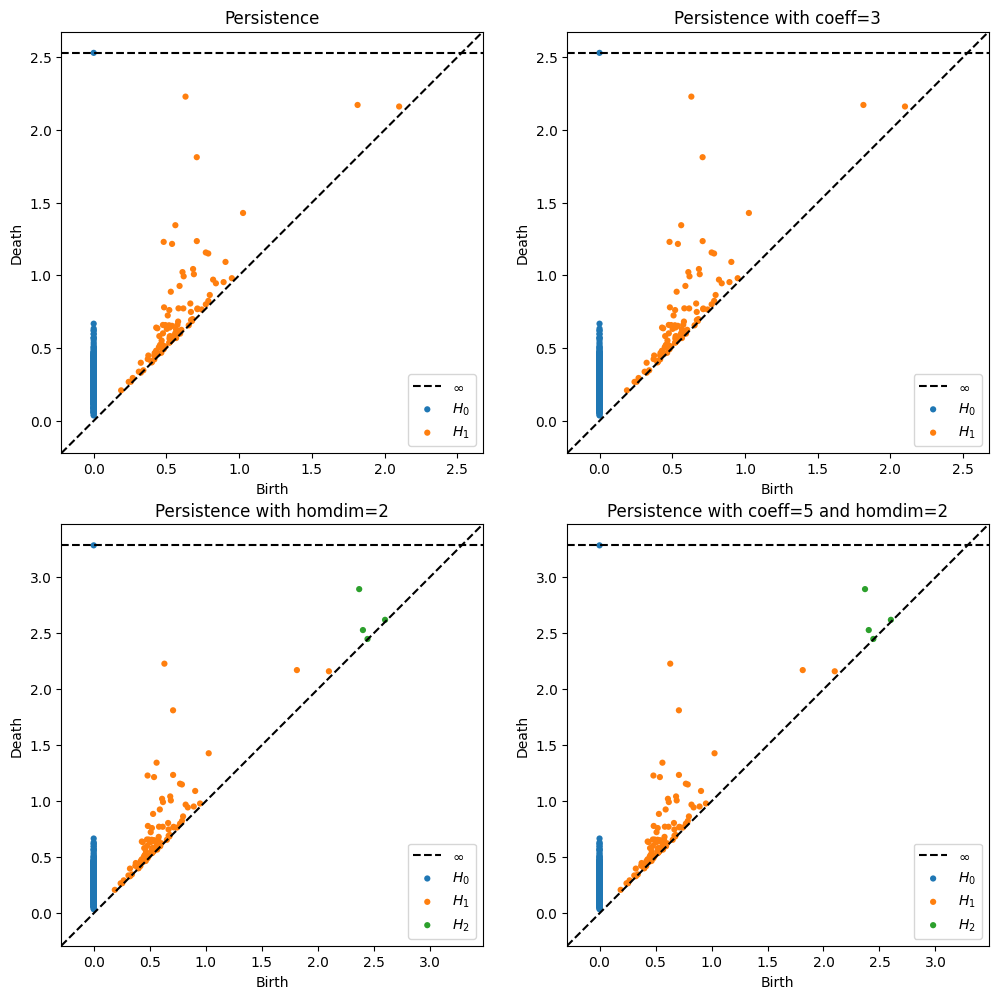

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(w_pad=3)
ax = ax.flatten()
ax[0].set_title('Persistence')
persistence(embed, ax=ax[0])
ax[1].set_title('Persistence with coeff=3')
persistence(embed, coeff=3, ax=ax[1])
ax[2].set_title('Persistence with homdim=2')
persistence(embed, homdim=2, ax=ax[2])
ax[3].set_title('Persistence with coeff=5 and homdim=2')
persistence(embed, coeff=5, homdim=2, ax=ax[3])


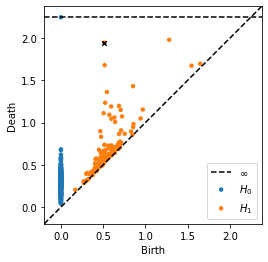

Decoding... done


In [4]:
# param = decoding.cohomological_parameterization(pd.DataFrame(firing_rates_in_trials_pca.reshape((400*50, -1))[::41]))
param = decoding.cohomological_parameterization(pd.DataFrame(embed))


In [63]:
param_corr[:, 0].shape

(788,)

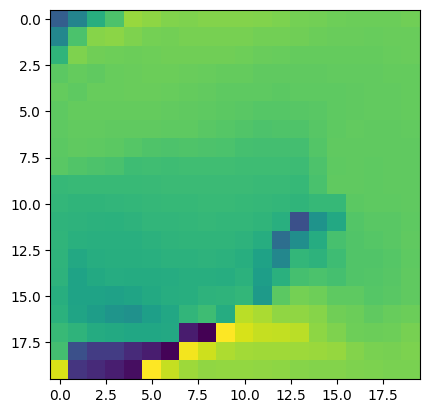

In [5]:
# plt.scatter(param_corr[:, 0], param_corr[:, 1], c=param.to_numpy())
plt.imshow(param.to_numpy().reshape((20, 20)))

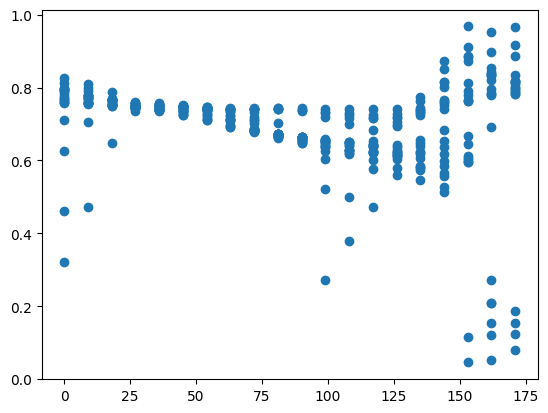

In [6]:
plt.scatter(param_corr[:, 0], param)

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

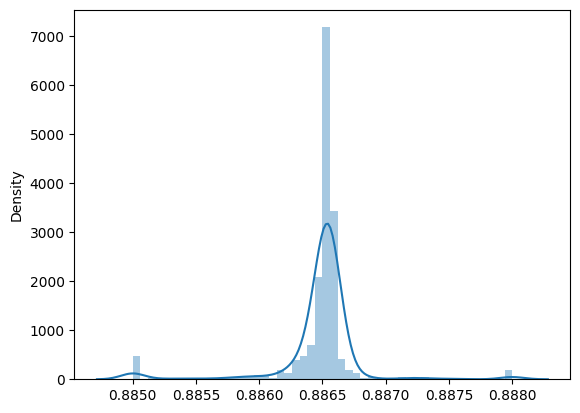

In [36]:
sns.distplot(param.clip(0.885, 0.888))

In [13]:
plt.imshow(gauss(np.random.uniform(size=(20, 20))))